In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import MSTL,AutoARIMA, SeasonalNaive, TBATS,OptimizedTheta,SeasonalExponentialSmoothingOptimized
import seaborn as sns
from datasetsforecast.losses import (
    mae, mape, mase, rmse, smape
)
import warnings 
warnings.filterwarnings('ignore') 

# Suppress future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load and prepare dataset
df = pd.read_csv('data.csv')

df.columns = [col.replace(".","_") for col in df.columns]

df["Date"] = pd.to_datetime(df["Date"])
df["Page_Loads"] = df["Page_Loads"].replace(",", "",regex=True).astype("int16")
df["Unique_Visits"] = df["Unique_Visits"].replace(",", "",regex=True).astype("int16")
df["Day_Of_Week"] = df["Day_Of_Week"].astype("int16")
df["First_Time_Visits"] = df["First_Time_Visits"].str.replace(",", "",regex=True).astype("int16")
df["Returning_Visits"] = df["Returning_Visits"].str.replace(",", "",regex=True).astype("int16")
df["unique_id"] = "1"

df.drop(columns="Row",inplace=True)
df.drop(columns="Day",inplace=True)
df.drop(columns="Day_Of_Week",inplace=True)





#df = df.rename(columns={'Date': 'ds', 'Page_Loads': 'y'})

print(df.describe())

# Splitting the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


        Page_Loads  Unique_Visits  First_Time_Visits  Returning_Visits
count  2167.000000    2167.000000        2167.000000       2167.000000
mean   4116.989386    2943.646516        2431.824181        511.822335
std    1350.977843     977.886472         828.704688        168.736370
min    1002.000000     667.000000         522.000000        133.000000
25%    3114.500000    2226.000000        1830.000000        388.500000
50%    4106.000000    2914.000000        2400.000000        509.000000
75%    5020.500000    3667.500000        3038.000000        626.500000
max    7984.000000    5541.000000        4616.000000       1036.000000


In [14]:
from prophet import Prophet
# Initialize and fit the Prophet model on the TRAINING data
model = Prophet()
model.fit(train_df)

# Create a future dataframe that covers the period of the test set
# Note: The test set's period is essentially from the last point in the training set to the end of the test set.
last_train_date = train_df['ds'].max()
first_test_date = test_df['ds'].min()
last_test_date = test_df['ds'].max()

# Ensure the future dataframe includes the test set period
future_dates = model.make_future_dataframe(periods=(last_test_date - last_train_date).days + 1, include_history=False)

# Predict the future with the model
forecast_prophet = model.predict(future_dates)
#print(forecast_prophet)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

            Page_Loads
Date                  
2014-09-14        2146
2014-09-15        3621
2014-09-16        3698
2014-09-17        3667
2014-09-18        3316
          ds     y unique_id
0 2014-09-14  2146         1
1 2014-09-15  3621         1
2 2014-09-16  3698         1
3 2014-09-17  3667         1
4 2014-09-18  3316         1


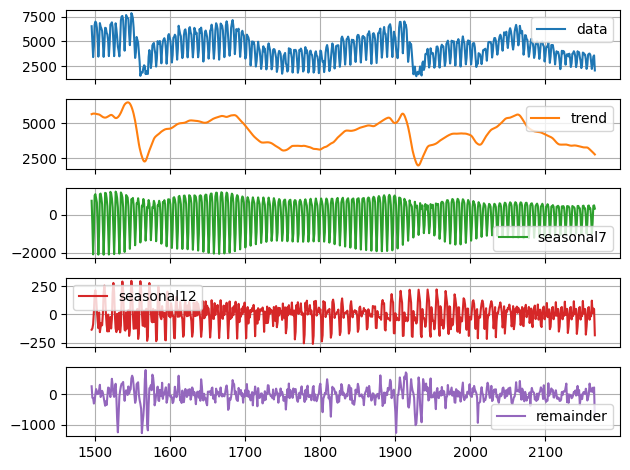

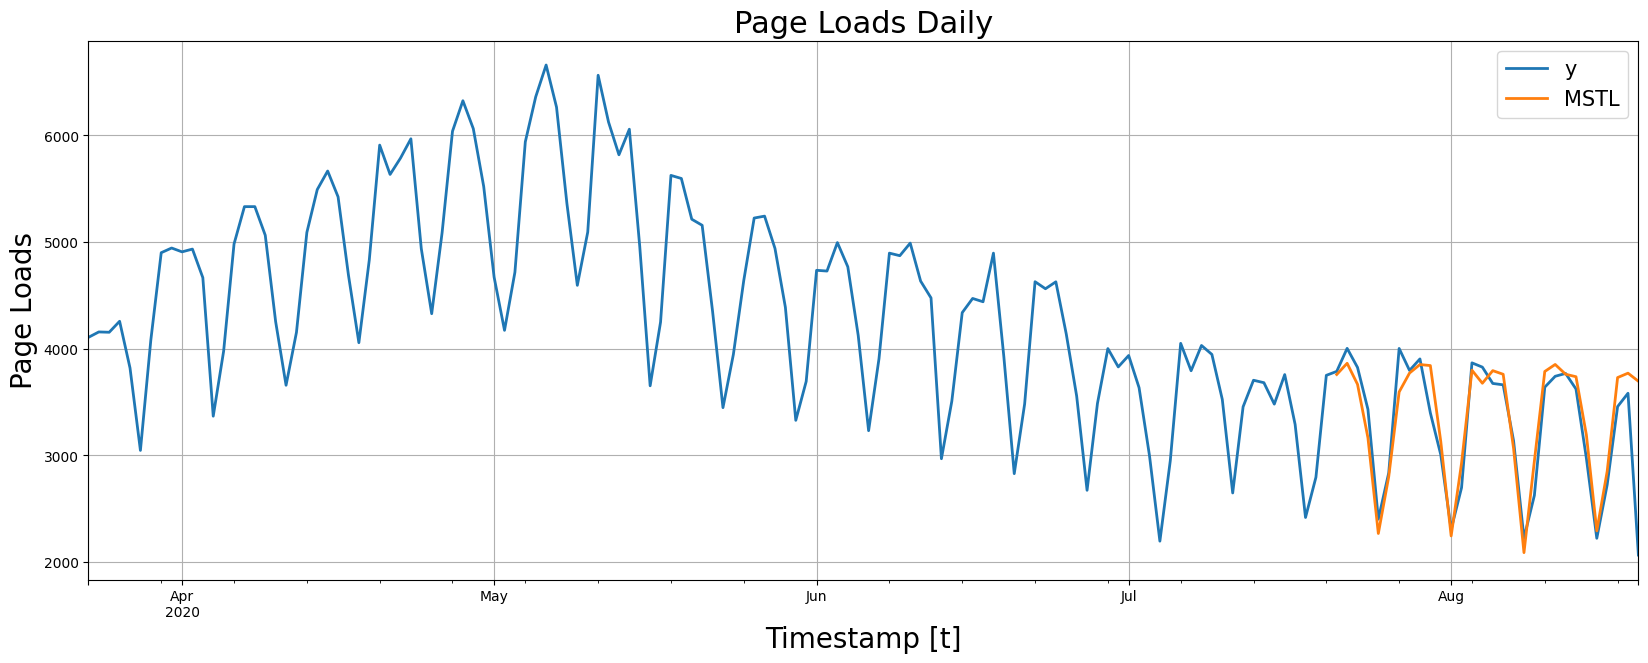

In [16]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

df.set_index("Date",inplace=True)
df.sort_index(inplace=True)

df_pl = df[["Page_Loads"]]

print(df_pl.head())

def transform_dataframe(df,target_column):
    df_transformed = df.reset_index()
    df_transformed.rename(columns={"Date": "ds", target_column: "y"}, inplace=True)
    df_transformed["unique_id"] = "1"
    return df_transformed
df_pl_transformed = transform_dataframe(df_pl,target_column="Page_Loads")

print(df_pl_transformed.head())

mstl = MSTL(
    season_length=[7,12], # seasonalities of the time series 
    trend_forecaster=AutoARIMA() # model used to forecast trend
)

sf = StatsForecast(
    models=[mstl], # model used to fit each time series 
    freq="D", # frequency of the data
)

def plot_forecasts(y_hist, y_true, y_pred, models,target_name):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how="left", on=["unique_id", "ds"])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(30*5)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
  
    ax.set_title(f"{target_name} Daily", fontsize=22)
    ax.set_ylabel(f"{target_name}", fontsize=20)
    ax.set_xlabel("Timestamp [t]", fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()
        
sf = sf.fit(df=df_pl_transformed)

sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True,)
plt.tight_layout()
plt.show()
df_test = df_pl_transformed.tail(30)
df_train = df_pl_transformed.drop(df_test.index)
sf = sf.fit(df=df_train)
forecasts_test = sf.predict(h=len(df_test))
plot_forecasts(df_train, df_test, forecasts_test, models=["MSTL"],target_name="Page Loads")

# Fit the model on the training DataFrame
#sf.fit(train_df[])

# Predict the future values
#forecast_nixtla = sf.predict(h=len(test_df))
#print(forecast_nixtla)
#print(forecast_nixtla.head())
#print(forecast_nixtla.columns)
#print(forecast_nixtla.index.names)



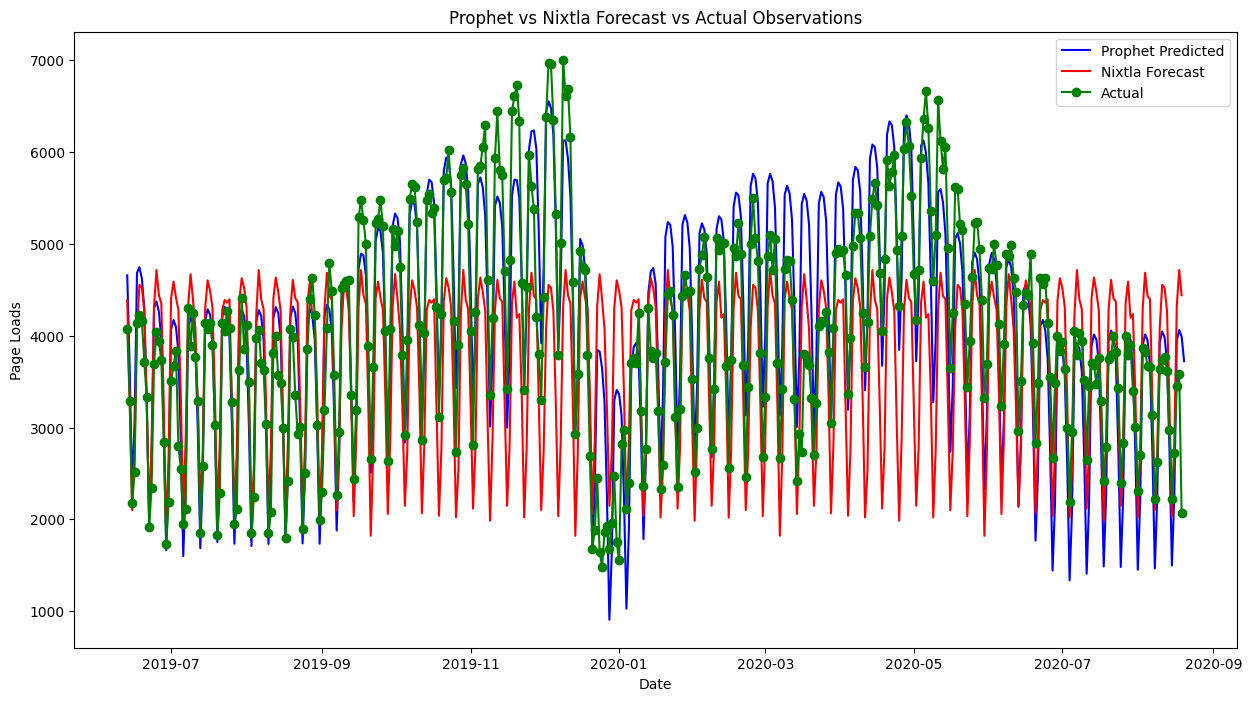

In [24]:
import matplotlib.pyplot as plt

#forecast_nixtla_reset = forecast_nixtla.reset_index()

# Plotting both forecasts for comparison
plt.figure(figsize=(15, 8))
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Predicted', color='blue')
plt.plot(forecast_nixtla['ds'], forecast_nixtla['MSTL'], label='Nixtla Forecast', color='red')
plt.plot(test_df['ds'], test_df['y'], label='Actual', color='green', marker='o')
plt.title('Prophet vs Nixtla Forecast vs Actual Observations')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from prophet import Prophet
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('data.csv')

# Rename columns to replace "." with "_"
df.columns = [col.replace(".", "_") for col in df.columns]

# Data type conversion and preprocessing
df["Date"] = pd.to_datetime(df["Date"])
df["Page_Loads"] = df["Page_Loads"].replace(",", "", regex=True).astype("int16")
df["Unique_Visits"] = df["Unique_Visits"].replace(",", "", regex=True).astype("int16")
df["First_Time_Visits"] = df["First_Time_Visits"].replace(",", "", regex=True).astype("int16")
df["Returning_Visits"] = df["Returning_Visits"].replace(",", "", regex=True).astype("int16")

# Dropping unnecessary columns and setting index
df.drop(columns=["Row", "Day", "Day_Of_Week", "Unique_Visits", "First_Time_Visits", "Returning_Visits"], inplace=True)
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)


In [19]:
# Prepare data for Prophet
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Page_Loads': 'y'})

# Splitting the dataset
train_size = int(len(df_prophet) * 0.8)
train_df_prophet = df_prophet[:train_size]
test_df_prophet = df_prophet[train_size:]

# Initialize and fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_df_prophet)

# Create a future dataframe for Prophet predictions
future_dates_prophet = model_prophet.make_future_dataframe(periods=len(test_df_prophet), include_history=False)
forecast_prophet = model_prophet.predict(future_dates_prophet)


16:06:26 - cmdstanpy - INFO - Chain [1] start processing
16:06:26 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Prepare data for Nixtla
df_nixtla = df.reset_index().rename(columns={'Date': 'ds', 'Page_Loads': 'y'})
df_nixtla["unique_id"] = "1"
# It's a good practice to check for NaN values before proceeding

# Splitting the dataset for Nixtla
train_size_nixtla = int(len(df_nixtla) * 0.8)

train_df_nixtla = df_nixtla[:train_size_nixtla]
print(train_df_nixtla.head())

test_df_nixtla = df_nixtla[train_size_nixtla:]

# Define and fit the Nixtla model
mstl = MSTL(season_length=[7, 12], trend_forecaster=AutoARIMA())
sf = StatsForecast(models=[mstl], freq="D")
sf = sf.fit(df=train_df_nixtla)

# Predict using Nixtla
forecasts_nixtla = sf.predict(h=len(test_df_nixtla))


          ds     y unique_id
0 2014-09-14  2146         1
1 2014-09-15  3621         1
2 2014-09-16  3698         1
3 2014-09-17  3667         1
4 2014-09-18  3316         1


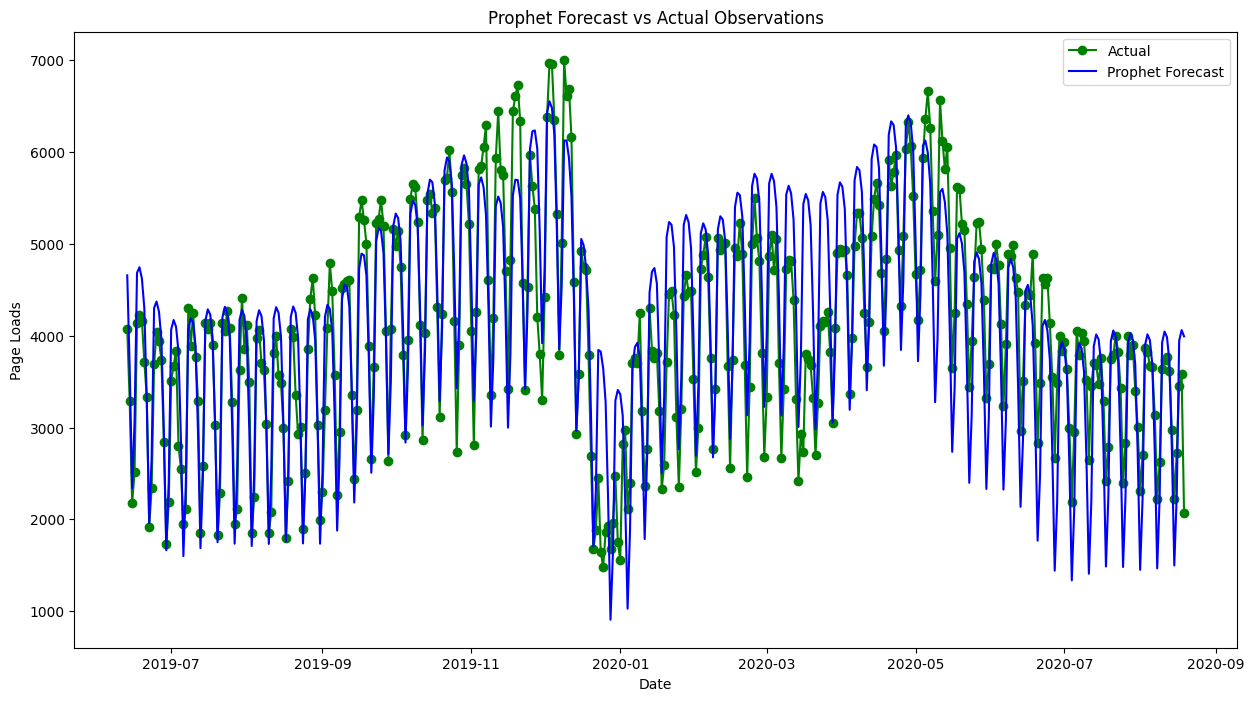

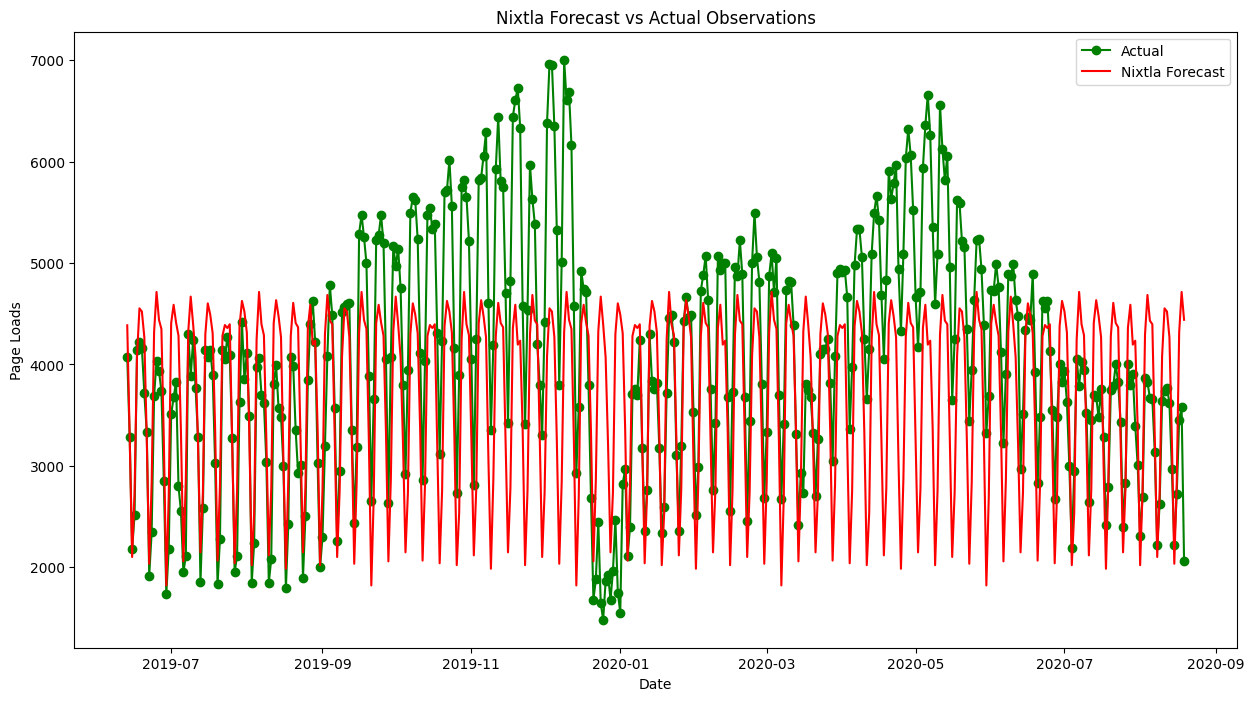

In [14]:
# Plotting the Prophet forecast
plt.figure(figsize=(15, 8))
plt.plot(test_df_prophet['ds'], test_df_prophet['y'], label='Actual', color='green', marker='o')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='blue')
plt.title('Prophet Forecast vs Actual Observations')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()

# Plotting the Nixtla forecast
plt.figure(figsize=(15, 8))
plt.plot(test_df_nixtla['ds'], test_df_nixtla['y'], label='Actual', color='green', marker='o')
plt.plot(test_df_nixtla['ds'], forecasts_nixtla['MSTL'], label='Nixtla Forecast', color='red')
plt.title('Nixtla Forecast vs Actual Observations')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()
